<a href="https://colab.research.google.com/github/Shreyash-Kale/FoodNet/blob/main/FoodNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **FoodNet** 🍔

An **end-to-end CNN Image Classification Model** which identifies the food in your image.

I worked out with a pretrained Image Classification Model that comes with Keras and then retrained it on the infamous **Food101 Dataset**.


**Fun Fact :**

The Model actually beats the DeepFood Paper's model which also trained on the same dataset.

The Accuracy of [**DeepFood**](https://arxiv.org/abs/1606.05675) was **77.4%** and our model's is **85%**. The interesting thing is, DeepFood's model took 2-3 days to train while our's was ~1.5 hrs.

> **Dataset :** `Food101`

> **Model :** `EfficientNetB1`





## **Setting up the Workspace**

* Checking the GPU
* Mounting Google Drive
* Importing Tensorflow and required Packages




### **Mounting Google Drive**




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Importing other required Packages**

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
import tensorflow_datasets as tfds
import seaborn as sn

#### **Importing `helper_fuctions`**

The `helper_functions.py` is a python script created by me. It has some important functions I use frequently while building Deep Learning Models.

In [ ]:
!wget https://raw.githubusercontent.com/Shreyash-Kale/FoodNet/main/helper_functions.py

In [ ]:
from helper_functions import plot_loss_curves, load_and_prep_image, unzip_data, create_tensorboard_callback

## **Getting the Data Ready**

The Dataset used is **Food101**, which is available on both Kaggle and Tensorflow.

In the below cells we will be importing Datasets from `Tensorflow Datasets` Module.


In [ ]:
# Prints list of Datasets avaible in Tensorflow Datasets Module

dataset_list = tfds.list_builders()
dataset_list[:10]

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'answer_equivalence']

### **Importing Food101 Dataset**

**Disclaimer :**
The below cell will take time to run, as it will be downloading
**4.65GB data** from **Tensorflow Datasets Module**.

So do check if you have enough **Disk Space** and **Bandwidth Cap** to run the below cell.

In [ ]:
(train_data, test_data), ds_info = tfds.load(name='food101',
                                             split=['train', 'validation'],
                                             shuffle_files=False,
                                             as_supervised=True,
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

## **Knowing the Data**



In [ ]:
ds_info.features

In [ ]:
class_names = ds_info.features['label'].names
class_names[:10]

In [ ]:
train_one_sample = train_data.take(1)

In [ ]:
train_one_sample

In [ ]:
for image, label in train_one_sample:
  print(f"""
  Image Shape : {image.shape}
  Image Datatype : {image.dtype}
  Class : {class_names[label.numpy()]}
  """)

In [ ]:
image[:2]

In [ ]:
tf.reduce_min(image), tf.reduce_max(image)

In [ ]:
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

## **Preprocessing the Data**





In [ ]:
def preprocess_img(image, label, img_size=224):
  image = tf.image.resize(image, [img_size, img_size])
  image = tf.cast(image, tf.float16)
  return image, label

In [ ]:
# Trying the preprocess function on a single image

preprocessed_img = preprocess_img(image, label)[0]
preprocessed_img

In [ ]:
train_data = train_data.map(preprocess_img, tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.AUTOTUNE)

test_data = test_data.map(preprocess_img, tf.data.AUTOTUNE)
test_data = test_data.batch(32)

In [ ]:
train_data

In [ ]:
test_data

## **Building the Model : EfficientNetB1**


### **Getting the Callbacks ready**

 * **TensorBoard Callback :** TensorBoard provides the visualization and tooling needed for machine learning experimentation

 * **EarlyStoppingCallback :** Used to stop training when a monitored metric has stopped improving.

 * **ReduceLROnPlateau :** Reduce learning rate when a metric has stopped improving.


In [ ]:
from helper_function import create_tensorboard_callback

In [ ]:
# EarlyStopping Callback

early_stopping_callback = tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=3, verbose=1, monitor="val_accuracy")

In [ ]:
# ReduceLROnPlateau Callback

lower_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.2,
                                                monitor='val_accuracy',
                                                min_lr=1e-7,
                                                patience=0,
                                                verbose=1)



### **Mixed Precision Training**



In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy='mixed_float16')

In [ ]:
mixed_precision.global_policy()

<Policy "mixed_float16">



### **Building the Model**

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB1(include_top=False)

# Input and Data Augmentation
inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs)

x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dropout(.3)(x)

x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax")(x)
model = tf.keras.Model(inputs, outputs)

# Compiling the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=["accuracy"])

27018416/27018416 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb1 (Functional  (None, None, None, 1280   6575239   
 )                           )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1280)              0         
 gePooling2D)                                                    
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 activation (Activation)     (None, 101)               0     

In [ ]:
history = model.fit(train_data,
                    epochs=10,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=int(0.15 * len(test_data)),
                    callbacks=[create_tensorboard_callback("training-logs", "EfficientNetB1-"),
                               early_stopping_callback,
                               lower_lr])

Saving TensorBoard log files to: training-logs/EfficientNetB1-/20231231-181713
Epoch 1/10
2368/2368 [==============================] - 662s 239ms/step - loss: 1.7547 - accuracy: 0.5566 - val_loss: 1.0355 - val_accuracy: 0.7222 - lr: 0.0010
Epoch 2/10
2368/2368 [==============================] - 560s 235ms/step - loss: 1.1371 - accuracy: 0.6981 - val_loss: 1.0176 - val_accuracy: 0.7230 - lr: 0.0010
Epoch 3/10
2368/2368 [==============================] - 556s 234ms/step - loss: 0.9271 - accuracy: 0.7473 - val_loss: 0.9467 - val_accuracy: 0.7524 - lr: 0.0010
Epoch 4/10
2368/2368 [==============================] - 557s 234ms/step - loss: 0.7678 - accuracy: 0.7858 - val_loss: 0.9355 - val_accuracy: 0.7572 - lr: 0.0010
Epoch 5/10
2368/2368 [==============================] - ETA: 0s - loss: 0.6551 - accuracy: 0.8146
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
2368/2368 [==============================] - 572s 241ms/step - loss: 0.6551 - accuracy: 0.8146 - val_l

In [ ]:
# Saving the model
model.save("/content/drive/MyDrive/FinalModel")

In [ ]:
# Saving the model
model.save("FoodNet")

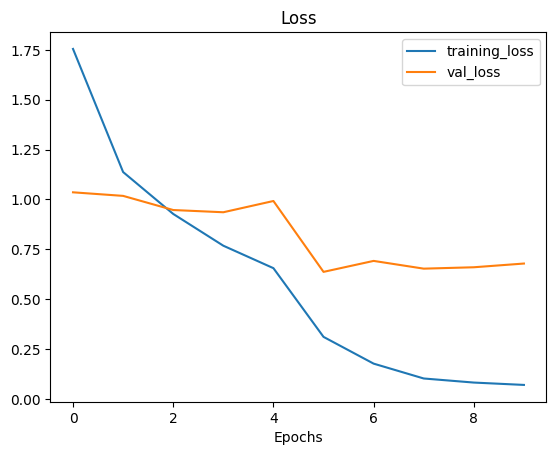

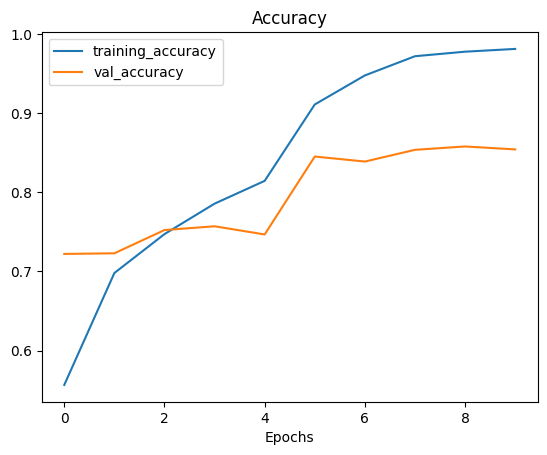

In [ ]:
plot_loss_curves(history)

In [ ]:
model.evaluate(test_data)

790/790 [==============================] - 57s 72ms/step - loss: 0.6992 - accuracy: 0.8419


[0.6992495656013489, 0.841861367225647]

## **Evaluating our Model**

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir training-logs

In [ ]:
pred_probs = model.predict(test_data, verbose=1)
len(pred_probs), pred_probs.shape

790/790 [==============================] - 64s 78ms/step


(25250, (25250, 101))

In [ ]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10], len(pred_classes), pred_classes.shape

(array([ 29,  81,  91,  53,  97,  97,  10,  31,   3, 100]), 25250, (25250,))

In [ ]:
# Getting true labels for the test_data

y_labels = []
test_images = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy())
y_labels[:10]

[29, 81, 91, 53, 97, 97, 10, 31, 3, 100]

In [ ]:
# Predicted Labels vs. True Labels
pred_classes==y_labels

array([ True,  True,  True, ..., False,  True, False])

### **Sklearn's Accuracy Score**

In [ ]:
from sklearn.metrics import accuracy_score

sklearn_acc = accuracy_score(y_labels, pred_classes)
sklearn_acc

0.8418613861386138

### **Confusion Matrix**
A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known

In [ ]:
cm = tf.math.confusion_matrix(y_labels, pred_classes)

plt.figure(figsize = (200, 200));
sn.heatmap(cm, annot=True,
           fmt='',
           cmap='Blues');

### **Model's Class-wise Accuracy Score**

In [ ]:
from sklearn.metrics import classification_report
report = (classification_report(y_labels, pred_classes, output_dict=True))

In [ ]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in report.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.6229508196721311,
 'baby_back_ribs': 0.8376753507014028,
 'baklava': 0.9065040650406505,
 'beef_carpaccio': 0.8951612903225806,
 'beef_tartare': 0.8076190476190476,
 'beet_salad': 0.768,
 'beignets': 0.8697394789579158,
 'bibimbap': 0.9354838709677419,
 'bread_pudding': 0.6541666666666667,
 'breakfast_burrito': 0.7664670658682634,
 'bruschetta': 0.7624750499001997,
 'caesar_salad': 0.8747591522157997,
 'cannoli': 0.8965517241379309,
 'caprese_salad': 0.8262548262548263,
 'carrot_cake': 0.7992047713717693,
 'ceviche': 0.7118644067796612,
 'cheesecake': 0.76,
 'cheese_plate': 0.9020408163265305,
 'chicken_curry': 0.7927565392354126,
 'chicken_quesadilla': 0.8508064516129031,
 'chicken_wings': 0.8893203883495147,
 'chocolate_cake': 0.7323943661971831,
 'chocolate_mousse': 0.6486486486486487,
 'churros': 0.9024390243902439,
 'clam_chowder': 0.8993839835728954,
 'club_sandwich': 0.8768267223382047,
 'crab_cakes': 0.7769230769230769,
 'creme_brulee': 0.9175050301810865,
 'cro

In [ ]:
report_df = pd.DataFrame(class_f1_scores, index = ['f1-scores']).T

In [ ]:
report_df = report_df.sort_values("f1-scores", ascending=True)

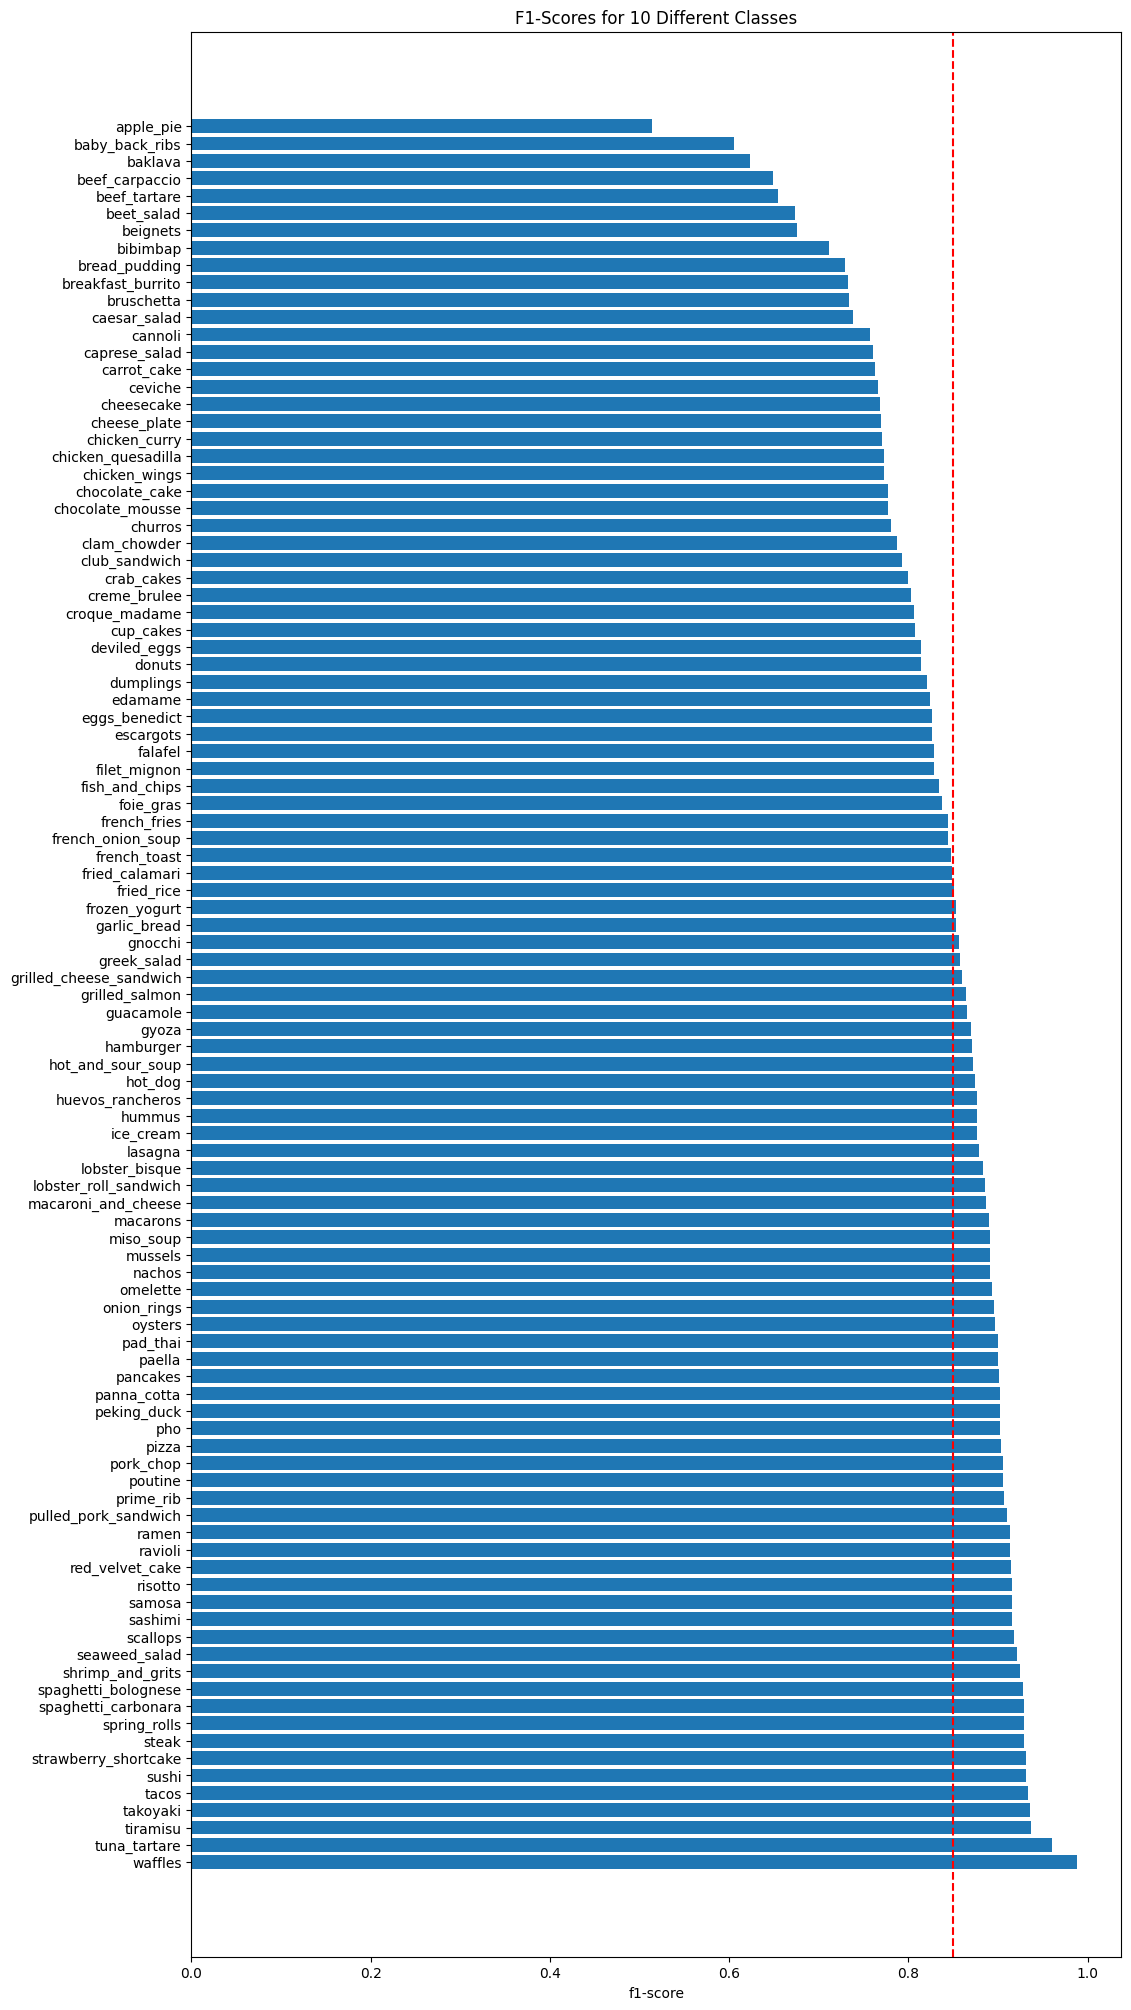

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(report_df)), report_df["f1-scores"].values)
ax.set_yticks(range(len(report_df)))
plt.axvline(x=0.85, linestyle='--', color='r')
ax.set_yticklabels(class_names)
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

### **Predicting on our own Custom images**





In [ ]:
# Get custom food images filepaths
import os

custom_food_images = ["/content/drive/MyDrive/custom_food_images/" + img_path for img_path in os.listdir("/content/drive/MyDrive/custom_food_images")]
custom_food_images

['/content/drive/MyDrive/custom_food_images/sushi.jpeg',
 '/content/drive/MyDrive/custom_food_images/chicken_wings.jpeg',
 '/content/drive/MyDrive/custom_food_images/samosa.jpg',
 '/content/drive/MyDrive/custom_food_images/falafel-patties.jpg']

In [ ]:
def pred_plot_custom(folder_path):
  import os

  custom_food_images = [folder_path + img_path for img_path in os.listdir(folder_path)]
  i=0
  fig,a =  plt.subplots(len(custom_food_images),2, figsize=(15, 5*len(custom_food_images)))

  for img in custom_food_images:
    img = load_and_prep_image(img, scale=False)
    pred_prob = model.predict(tf.expand_dims(img, axis=0))
    pred_class = class_names[pred_prob.argmax()]
    top_5_i = (pred_prob.argsort())[0][-5:][::-1]
    values = pred_prob[0][top_5_i]
    labels = []
    for x in range(5):
      labels.append(class_names[top_5_i[x]])

    # Plotting Image
    a[i][0].imshow(img/255.)
    a[i][0].set_title(f"Prediction: {pred_class}   Probability: {pred_prob.max():.2f}")
    a[i][0].axis(False)

    # Plotting Models Top 5 Predictions
    a[i][1].bar(labels, values, color='orange');
    a[i][1].set_title('Top 5 Predictions')
    i=i+1

1/1 [==============================] - 0s 32ms/step


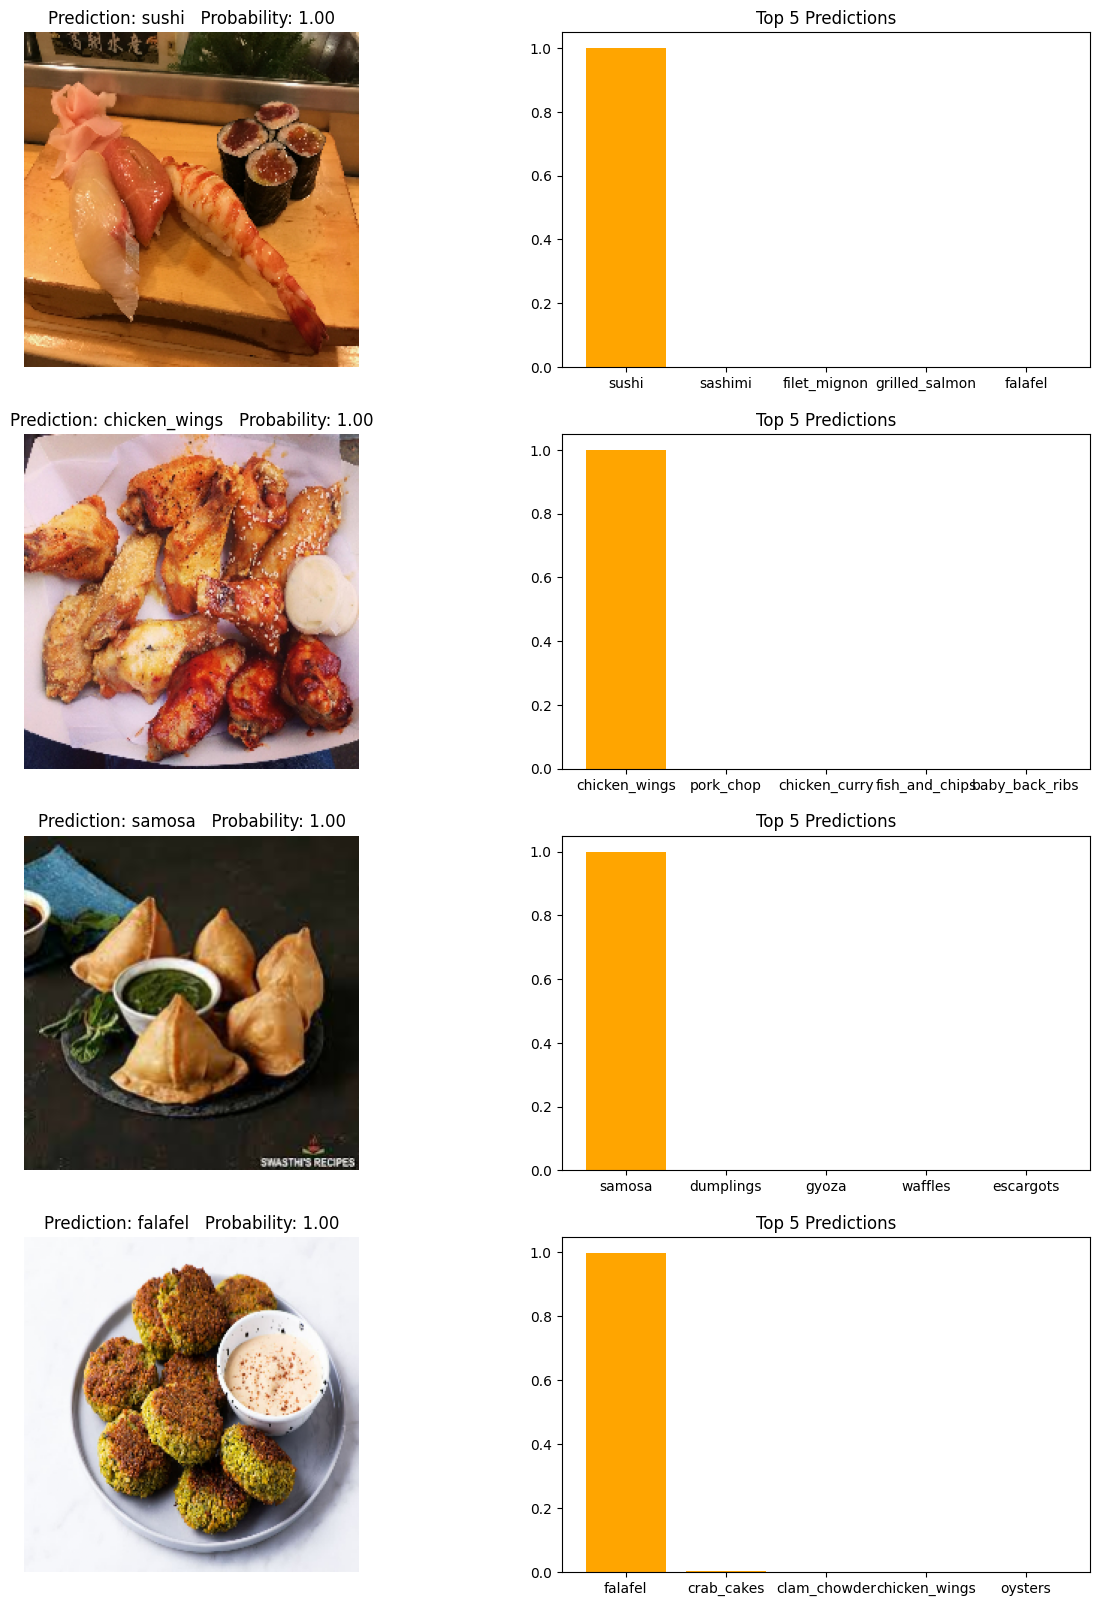

In [ ]:
pred_plot_custom("/content/drive/MyDrive/custom_food_images/")
